# Building a handwritten digits classifier

Within the field of machine learning, image classification is not the easiest of tasks. Images are highly-dimesional: basically, every pixel can be considered a 'feature', having a lot of possible values (such as color codes). To reduce such complexity and keep processing times for machine learning within reasonable limits, images are typically downscaled; but that also implies a loss of information that makes the task at hand more difficult again. Also, the features in an image don't have an obvious linear (or nonlinear) relationship that can be learned with a model like linear or logistic regression. 

In the project, I'll do an attempt to train and test several models that classify hand-written digits (0-9). Different models will be used and compared in terms of accuracy:
* K Nearest Neighbors
* Neural networks (with different numbers of layers)

The data that will be used is a [hand-written digits dataset from UCI](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits). That is, a copy of this dataset is readily available as part of the [scikit-learn](https://scikit-learn.org/stable/) packages. Function [load_digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) returns a labeled set of 1797 images (ranging 0-9), each consisting of 8x8 bits (= 64 feautures) having a value (ranging 0-16) representing its gray-scale.

Structure of this notebook:
* 1. Preparations and data exploration
* 2. K Nearest Neighbors classification (KNN)
* 3. Neural network (single hidden layer)
* 4. Neural network (multiple hidden layers)
* 5. Conclusions and possible next steps

## 1. Preparations and data exploration

In this section we will first do some preparations such as importing all libraries. Then the data will be imported and explored, so we have a good understanding of the data prior to using it for a predictive model.

In [1]:
# Import relevant libraries etc.

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

In [2]:
# Import the data (via a built-in function of sci-kit learn)

digits = load_digits()

In [3]:
# Get some statistics, to understand data quantity and structure
print(type(digits.data))
print(digits.data.shape)
print(type(digits.target))
print(digits.target.shape)
print(type(digits.images))
print(digits.images.shape)

<class 'numpy.ndarray'>
(1797, 64)
<class 'numpy.ndarray'>
(1797,)
<class 'numpy.ndarray'>
(1797, 8, 8)


In [4]:
# Show a sample of digits.data, to understand data structure
digits.data[0:2]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,
         9.,  0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7.,
        15., 16., 16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,
         0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16.,
        16.,  6.,  0.,  0.,  0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

In [5]:
# Show a sample of digits.target, to understand data structure
digits.target[0:2]

array([0, 1])

In [6]:
# Show a sample of digits.images, to understand data structure
digits.images[0:2]

array([[[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
        [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
        [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
        [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
        [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
        [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
        [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
        [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
        [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
        [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
        [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
        [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
        [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
        [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
        [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]]])

So (as mentioned in the introduction) indeed every image is represented by 8x8 pixels, each having a value in range 0 - 16.
This is captured in `digits.data` in arrays of 64 numbers and in `digits.images` in 8 arrays of 8 numbers, for every image. In `digits.target` we find the labels: the numbers that the images represent.

The indices align, so if we take instance [352] of the images the corresponding label is also instance [352]. 

Let's plot a sample to get a better insight in what the images actually looks like, together with their labels.

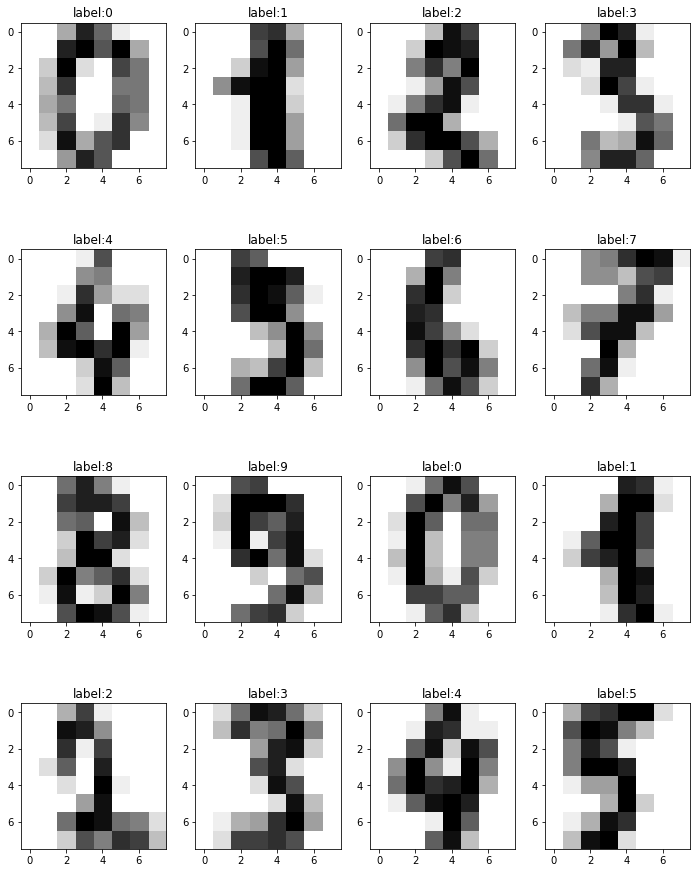

In [7]:
# Plot a sample: the first 16 images of the dataset (with their label)

fig = plt.figure(figsize=(12, 16))
columns = 4
rows = 4

for i in range(1, columns*rows +1 ):
    img = digits.images[i-1]
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text('label:' + str(digits.target[i-1]))
    plt.imshow(img, cmap='gray_r')

plt.show()

Any data cleaning or pre-processing doesn't seem to be required.

So, having good understanding of the data now, let's continue with machine learning.

## 2. K Nearest Neighbors classification (KNN)

The first predictive model that we'll create will be be a K Nearest Neighbors classification model.

Let me try to explain what this comes down to, in layman's terms. When requested to classify an image, what will be done is finding the K "most similar", or "nearest" images in terms of gray-scale of their pixels. Similarity (near-ness) of two images is calculated by taking all 64 feature values (that is: gray-scales) of both images, and then calculate the "[Eucledian Distance](https://en.wikipedia.org/wiki/Euclidean_distance)" between the pictures. The lower this Eucledian distance the "nearer" these images are. Then, once the K nearest neighbors of the to-be-classified image have been found, the classification is done based on a "majority vote" of the labels of these K neighbors. 

For efficient experiments, we'll start with defining functions to train and to test (predict). The test function will then return an accuracy: the fraction of the test set of which the prediction was correct.

Note that for KNN, there actually is not really something like 'training' in a sense that it will calculate any parameters. What the training comes down to technically is arranging the dataset in such way that the look-up process performed during 'testing' can be done efficiently. 

What I also will not add is 'testing on the training set', a practice in machine learning to detect overfitting. The trained model did not 'learn' anything, it is just a set of images to find similar ones in. Actually, testing on the training set would imply something very odd, as the most similar image in the training set would always be.... the image itself! So that would always be included in the selection of 'nearest neighbors', giving overly optimistic results; for k=1 the accuracy would even end-up at 100%!

In [8]:
# Define function to train (which in case of KNN comes down to efficient storage of the dataset)
# Inputs: training data, training data labels, K value (nr of neighbors)
# Outputs: trained model

def knn_train(train_features, train_labels, k = 5):
    
    # Instantiate KNN object
    knn = KNeighborsClassifier(k)
    
    # Train
    knn.fit(train_features, train_labels)
    
    # Return trained model
    return knn

In [9]:
# Define function to predict, and calculate the accuracy 
# Inputs: trained model, test data, test data labels
# Outputs: accuracy of predictions

def knn_test(trained_knn_model, test_features, test_labels, printdetails = False):
    
    # Test
    predictions = trained_knn_model.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    if printdetails == True:
        print ('Predicted values:', predictions)
        print ('Actual values: ', test_labels)   
        print ('Accuracy: ', accuracy)
    
    return accuracy

To verify/validate the two functions just specified, let's run a quick test with some subsets of the data. The first 100 instances will be offered to 'train', the next 50 to 'test'. In layman's terms: what will happen is that for each of instances 101-150, the k nearest neighbors ('most similar images') will be found in the first 100 instances to detect which digit it most likely represents.

In [10]:
# Specify a small data sample as `training` set (the first 100 instances)
some_features = digits.data[0:101]
some_labels = digits.target[0:101]

In [11]:
# Run them past the `train` function
trial_trained_knn_model = knn_train(some_features, some_labels, k=3)

In [12]:
# Specify a small data sample as `test` set (instances 101-150)
other_features = digits.data[101:151]
other_labels = digits.target[101:151]

In [13]:
# Run them past the 'test' function, and print the results
knn_test(trial_trained_knn_model, other_features, other_labels, printdetails = True)

Predicted values: [0 5 3 6 9 6 1 7 5 4 4 7 2 8 2 2 5 7 9 5 4 8 8 4 3 0 8 9 8 0 1 2 3 1 5 6 7
 8 9 0 1 2 3 1 5 6 7 8 9 0]
Actual values:  [0 5 3 6 9 6 1 7 5 4 4 7 2 8 2 2 5 7 9 5 4 8 8 4 9 0 8 9 8 0 1 2 3 4 5 6 7
 8 9 0 1 2 3 4 5 6 7 8 9 0]
Accuracy:  0.94


0.94

It looks like this does what it is supposed to do. And actually, the result is quite promising! Even with such a small amount of data, an accuracy of 94% percent is achieved! One "9" was misclassified as a "3", and two times a "1" as a "4", all others were correct.

Let's proceed with doing 'train' and 'test' in a more structural way, using K-fold validation. We'll set K to 4, so that means that we will 4 times train a model using 75% of the data, and then using the remaining 25% to test. This results in 4 calculated accuracies, and the mean of those is the function's output.

In [14]:
# Define function to do 4-fold cross validation using knn-train and knn-test functions specified above

def knn_cross_validate(features, labels, k=3, printdetails = False ):
    
    # Instantiate list with results per fold
    fold_accuracies = []
    
    # Instantiate kfold to split the data (randomly but reproducable)
    kfold = KFold(n_splits = 4, shuffle = True, random_state = 0)
    
    # Iterate over the 4 folds
    for train_indices, test_indices in kfold.split(features): # Get the indices using 'features'; they map correctly with 'labels'
        
        # Get train and test features
        fold_train_features = features[train_indices]  
        fold_test_features = features[test_indices] 
        
        # Get train and test labels
        fold_train_labels = labels[train_indices]
        fold_test_labels = labels[test_indices]
        
        # Check whether this does what it is supposed to do
        # print(test_indices)
        # print(fold_test_labels)
        
        # Train model for this fold (and return trained model)
        fold_trained_model = knn_train(fold_train_features, fold_train_labels, k)
        
        # Test model for this fold (and return calculated accuracy)
        fold_accuracy = knn_test(fold_trained_model, fold_test_features, fold_test_labels)
        
        if printdetails == True:
            print('Accuracy of this fold:', fold_accuracy)
        
        # Add accuracy to list
        fold_accuracies.append(fold_accuracy)
        
    # Calculate overall result: the mean of the accuracies of all folds
    accuracy = np.mean(fold_accuracies)
    return (accuracy)

Let's do a quick run of this to test it out.

In [15]:
# Test out cross validation, using k=3
knn_cross_validate(digits.data, digits.target, k=3, printdetails = True)

Accuracy of this fold: 0.9866666666666667
Accuracy of this fold: 0.9844097995545658
Accuracy of this fold: 0.9866369710467706
Accuracy of this fold: 0.9799554565701559


0.9844172234595397

Looks like it is doing what it is supposed to do, and the result is impressive! The accuracy if 98.4%.

Let's next experiment with different values of k (=number of neighbors), to see the effect of that on the accuracy.

In [16]:
# Run cross-validation for KNN for different values of k

# Instantiate list with range of k-values
kvalues = list(range(1,21))

# Instantiate list with results
kvalues_accuracies = []

# Run KNN-cross-validation (in its turn running train and test) for all k-values in the specified range
for kvalue in kvalues:
    # Calculate accuracy (cross-validated)
    k_accuracy = knn_cross_validate(digits.data, digits.target, k = kvalue)
    
    # Append result
    kvalues_accuracies.append(k_accuracy)

# Print results
print('Values of k:', kvalues)
print('Corresponding accuracies:', kvalues_accuracies)

Values of k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Corresponding accuracies: [0.9866419203167534, 0.9816344964117792, 0.9844172234595397, 0.982750556792873, 0.9821937639198218, 0.9810826528087108, 0.9821950012373174, 0.9833085869834199, 0.9827517941103687, 0.9805258599356594, 0.9777431328878989, 0.9794135115070528, 0.9766307844592923, 0.9771875773323435, 0.9766307844592923, 0.974404850284583, 0.9749653551101212, 0.9727381836179163, 0.9721813907448651, 0.971066567681267]


Let's show this in a graph.

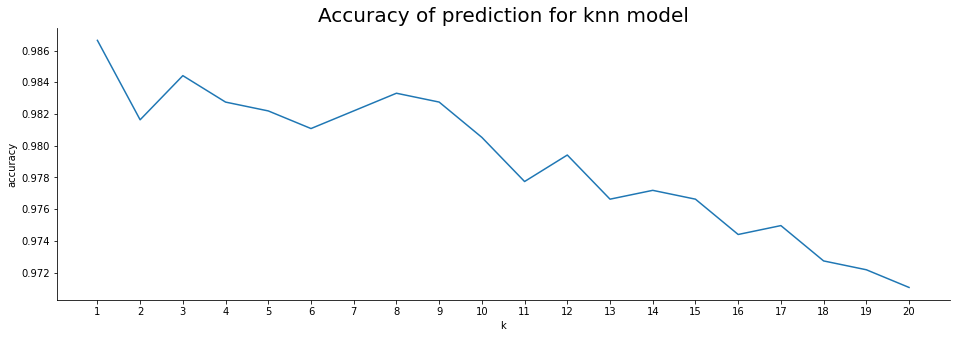

In [17]:
# Show a line graph of the results
fig,ax = plt.subplots(figsize=(16, 5))
plt.plot(kvalues,kvalues_accuracies)
plt.title('Accuracy of prediction for knn model', fontsize=20)
ax.set_xticks(kvalues)
ax.set_xlabel('k')
ax.set_ylabel('accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

We see that with a growing number of k the accuracy gradually drops. Actually, we get the best result with a value of k=1. That is: the best way to predict a digit in the test set, is to use the digit of the single most 'similar picture' from the training set. Rather than the 'majority vote' of the k most similar pictures.

This gives an accuracy of 98.7%

## 3. Neural network (single hidden layer)

Let's now create a second predictive model: a neural network.

Explaining what that is or does in layman's terms is something that is beyond my capacities, I'm afraid. I cannot give a better advice than doing a search on the internet with terms like "neural network explained" or "neural network in layman's terms", and find out which description or video resonates with you. One that may be helpful is [this one](https://www.bmc.com/blogs/neural-network-introduction/), also as it uses handwritten digit classification as an example. *(Note: I am aware that this description is from a commercial organization. I have **no** personal stake in this organization, in fact had never heard of it until I was myself doing some web search on simple explanations of neural networks.)*

We will start with a multi-layered perceptron (MLP) neural network with a single hidden layer. For the activitation function 'logistic' is used (being Sigmoid function) as this is suitable for classification problems.

For efficient experiments, we basically we apply the same structure as above with train, test and cross-validation. Where the result is accuracy again: the fraction of correct predictions. The hyperparameters to tune are different of course.

What I will add (which was not included for KNN) is testing on the training data as well, to detect overfitting.

In [18]:
# Define function to train (MLP classifier)
# Inputs: training data, training data labels, network layer sizes, maximum number of iterations
# Outputs: trained model

def mlp_train(train_features, train_labels, hiddenlayersizes = (1,), maxiterations = 200):
    
    # Instantiate MLP object (set random seed for reproducable results)
    mlp = MLPClassifier(hidden_layer_sizes = hiddenlayersizes, activation = 'logistic', max_iter = maxiterations, random_state = 0)
    
    # Train
    mlp.fit(train_features, train_labels)
    
    # Return trained model
    return mlp

In [19]:
# Define function to predict, and calculate the accuracy 
# Inputs: trained model, test data, test data labels
# Outputs: accuracy of predictions

def mlp_test(trained_mlp_model, test_features, test_labels, printdetails = False):
    
    # Test
    predictions = trained_mlp_model.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    if printdetails == True:
        print ('Predicted values:', predictions)
        print ('Actual values: ', test_labels)   
        print ('Accuracy: ', accuracy)
    
    return accuracy

Just as we did before with KNN, let's do a quick initial test with some small subsets of the data. We reuse the same samples (first 100 instances to train, next 50 instances to test.)

In [20]:
# Run the MLP train function with the first 100 instances of the data, with 8 neurons 
trial_trained_mlp_model = mlp_train(some_features, some_labels, hiddenlayersizes = (8,), maxiterations = 200)

C:\Users\jaspe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [21]:
# Test this on the next 50 instances of the data
mlp_test(trial_trained_mlp_model, other_features, other_labels, printdetails = True)

Predicted values: [0 5 3 6 0 6 1 7 5 7 4 7 9 2 2 6 5 7 9 9 4 3 9 4 9 0 9 9 9 0 1 9 3 4 5 6 7
 9 9 0 1 9 3 4 2 6 7 6 9 0]
Actual values:  [0 5 3 6 9 6 1 7 5 4 4 7 2 8 2 2 5 7 9 5 4 8 8 4 9 0 8 9 8 0 1 2 3 4 5 6 7
 8 9 0 1 2 3 4 5 6 7 8 9 0]
Accuracy:  0.7


0.7

Good, it looks like the single-layer neural network does do something indeed.
However we observe that:
* the model did not converge yet (warning given)
* the accuracy (of 70%) is pretty poor at this point (compared to KNN)

There are two things to experiment with:
* the maximum number of iterations (which was set to 200)
* the number of neurons in the hidden layer (which was set to 8)

Let us only do those things though once working with the full data set.

Similar as above, let's implement 4-fold validation. Or, in this case, we'll make the number of folds a parameter (defaulted to 4) so that we can later experiment with it. The result will contain two accuracies: the accuracy when testing on the training data itself, and the accuracy when testing on the test data.

In [22]:
# Define function to do k-fold cross validation using mlp-train and mlp-test functions specified above

def mlp_cross_validate(features, labels, folds = 4, hiddenlayersizes = (1,), maxiterations = 200, printdetails = False ):
    
    # Instantiate lists with results per fold
    fold_accuracies_traindata = []
    fold_accuracies_testdata = []
        
    # Instantiate kfold to split the data (randomly but reproducable)
    kfold = KFold(n_splits = folds, shuffle = True, random_state = 0)
    
    # Iterate over the folds
    for train_indices, test_indices in kfold.split(features): # Get the indices using 'features'; they map correctly with 'labels'
        
        # Get train and test features
        fold_train_features = features[train_indices]  
        fold_test_features = features[test_indices] 
        
        # Get train and test labels
        fold_train_labels = labels[train_indices]
        fold_test_labels = labels[test_indices]
                  
        # Train model for this fold (and return trained model)
        fold_trained_model = mlp_train(fold_train_features, fold_train_labels, hiddenlayersizes, maxiterations)
        
        ### Testing with TRAIN data
        
        # Test model for this fold (and return calculated accuracy)
        fold_accuracy_traindata = mlp_test(fold_trained_model, fold_train_features, fold_train_labels)
        
        if printdetails == True:
            print('Accuracy of this fold (train data):', fold_accuracy_traindata)
        
        # Add accuracy to list
        fold_accuracies_traindata.append(fold_accuracy_traindata)
        
        ### Testing with TEST data
        
        # Test model for this fold (and return calculated accuracy)
        fold_accuracy_testdata = mlp_test(fold_trained_model, fold_test_features, fold_test_labels)
        
        if printdetails == True:
            print('Accuracy of this fold (test data):', fold_accuracy_testdata)
        
        # Add accuracy to list
        fold_accuracies_testdata.append(fold_accuracy_testdata)
        
    # Calculate overall result: the mean of the accuracies of all folds
    accuracy_train = np.mean(fold_accuracies_traindata)
    accuracy_test = np.mean(fold_accuracies_testdata)
    return (accuracy_train, accuracy_test)

Let's do a quick run of this to test it out.

In [23]:
# Test out cross validation, using 8 neurons and a maximum of 200 iterations
mlp_cross_validate(digits.data, digits.target, hiddenlayersizes = (8,), maxiterations = 200, printdetails = True)

C:\Users\jaspe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of this fold (train data): 0.9569413511507052
Accuracy of this fold (test data): 0.8955555555555555


C:\Users\jaspe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of this fold (train data): 0.9688427299703264
Accuracy of this fold (test data): 0.9086859688195991


C:\Users\jaspe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of this fold (train data): 0.9495548961424333
Accuracy of this fold (test data): 0.9242761692650334
Accuracy of this fold (train data): 0.962166172106825
Accuracy of this fold (test data): 0.9287305122494433


C:\Users\jaspe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(0.9593762873425725, 0.9143120514724078)

We see quite a significant difference between accuracies on train and test data, indicating overfitting.

However, the most important observation at this point is that we see the non-convergence warnings for every fold.

Let's try to address that, and experiment with a higher value of maximum number of iterations. This will go at the expense of performance though (it will take time), so we also don't want to set it higher than necessary. So let's first try to find a value where we don't get warnings, and then use binary search to find a number between that upper bound, and our lower bound of 200 to find a good value.

Let's start with a value of max iterations of 2000.

In [24]:
# Test out cross validation with max_iter 2000
mlp_cross_validate(digits.data, digits.target, hiddenlayersizes = (8,), maxiterations = 2000, printdetails = True)

Accuracy of this fold (train data): 0.9955456570155902
Accuracy of this fold (test data): 0.9155555555555556
Accuracy of this fold (train data): 0.9985163204747775
Accuracy of this fold (test data): 0.9287305122494433
Accuracy of this fold (train data): 0.994807121661721
Accuracy of this fold (test data): 0.9465478841870824
Accuracy of this fold (train data): 0.9940652818991098
Accuracy of this fold (test data): 0.9354120267260579


(0.9957335952627996, 0.9315614946795348)

So a value of 2000 for maximum iterations never gives the non-convergence warning. So let's find a value between 200 and 2000 using binary search.

In [25]:
# Test out cross validation with max_iter 1000
mlp_cross_validate(digits.data, digits.target, hiddenlayersizes = (8,), maxiterations = 1000, printdetails = True)

C:\Users\jaspe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of this fold (train data): 0.991833704528582
Accuracy of this fold (test data): 0.9222222222222223


C:\Users\jaspe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of this fold (train data): 0.9985163204747775
Accuracy of this fold (test data): 0.9309576837416481


C:\Users\jaspe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of this fold (train data): 0.9940652818991098
Accuracy of this fold (test data): 0.9443207126948775
Accuracy of this fold (train data): 0.9925816023738873
Accuracy of this fold (test data): 0.9287305122494433


C:\Users\jaspe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(0.994249227319089, 0.9315577827270478)

In [26]:
# Test out cross validation with max_iter 1500
mlp_cross_validate(digits.data, digits.target, hiddenlayersizes = (8,), maxiterations = 1500, printdetails = True)

Accuracy of this fold (train data): 0.9955456570155902
Accuracy of this fold (test data): 0.9155555555555556
Accuracy of this fold (train data): 0.9985163204747775
Accuracy of this fold (test data): 0.9287305122494433
Accuracy of this fold (train data): 0.994807121661721
Accuracy of this fold (test data): 0.9465478841870824
Accuracy of this fold (train data): 0.9940652818991098
Accuracy of this fold (test data): 0.9354120267260579


(0.9957335952627996, 0.9315614946795348)

In [27]:
# Test out cross validation with max_iter 1250
mlp_cross_validate(digits.data, digits.target, hiddenlayersizes = (8,), maxiterations = 1250, printdetails = True)

Accuracy of this fold (train data): 0.9955456570155902
Accuracy of this fold (test data): 0.9155555555555556
Accuracy of this fold (train data): 0.9985163204747775
Accuracy of this fold (test data): 0.9287305122494433


C:\Users\jaspe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of this fold (train data): 0.994807121661721
Accuracy of this fold (test data): 0.9487750556792873
Accuracy of this fold (train data): 0.9940652818991098
Accuracy of this fold (test data): 0.9354120267260579


(0.9957335952627996, 0.932118287552586)

It looks like 1500 is a value for max_iter (maximum number of iterations) for which we don't get the warning anymore that the model did not converge yet. The accuracy gain compared to somewhat lower values (such as 1000 and 1250) is quite limited, but since the run times are acceptable still, let's consider 1500 iterations a good value to go with.

That is, that worked for 8 neurons. It is not said that for more neurons we don't get convergence issues again. Let's try 1500 iterations as well for 256 neurons, the highest number that we are going to experiment with.

In [28]:
# Test out cross validation with max_iter 1500 and 256 neurons
mlp_cross_validate(digits.data, digits.target, hiddenlayersizes = (256,), maxiterations = 1500, printdetails = True)

Accuracy of this fold (train data): 1.0
Accuracy of this fold (test data): 0.98
Accuracy of this fold (train data): 1.0
Accuracy of this fold (test data): 0.9844097995545658
Accuracy of this fold (train data): 1.0
Accuracy of this fold (test data): 0.9821826280623608
Accuracy of this fold (train data): 1.0
Accuracy of this fold (test data): 0.9844097995545658


(1.0, 0.9827505567928732)

Also for that experiment, no warnings about non-convergence, so that appears to work. We'll stick to 1500 for maximum number of iterations.

With that, let us now move on with experiments with different numbers of neurons in the model: 8, 16, 32, 64, 128, 256.

In [29]:
# Run cross-validation for MLP for different values of hidden-layer-sizes (nr of neurons)

# Instantiate list with range of number of neurons
numberofneurons = [8, 16, 32, 64, 128, 256, 512]

# Instantiate the corresponding arrays that the model needs as input
hiddenlayersizes_arrays = [(8,),(16,),(32,),(64,),(128,),(256,),(512,)]

# Instantiate list with results
numberofneurons_accuracies = []

# Run MLP-cross-validation (in its turn running train and test) for all hiddenlayersizes in the specified range
for hls_array in hiddenlayersizes_arrays:
    # Calculate accuracy (cross-validated)
    hls_accuracy = mlp_cross_validate(digits.data, digits.target, hiddenlayersizes = hls_array, maxiterations = 1500)
    
    # Append result
    numberofneurons_accuracies.append(hls_accuracy)

# Print results    
print('Number of neurons (in single layer):', numberofneurons)
print('Corresponding accuracies:', numberofneurons_accuracies)

Number of neurons (in single layer): [8, 16, 32, 64, 128, 256, 512]
Corresponding accuracies: [(0.9957335952627996, 0.9315614946795348), (0.9985161827910798, 0.9565961395694136), (1.0, 0.9788554813165058), (1.0, 0.9788542439990102), (1.0, 0.9816382083642663), (1.0, 0.9827505567928732), (1.0, 0.9816394456817621)]


Let's plot these results in a graph.

In [30]:
# First convert the results to a different format for simpler plotting
numberofneurons_accuracies_train = []
numberofneurons_accuracies_test = []

for an_array in numberofneurons_accuracies:
    numberofneurons_accuracies_train.append(an_array[0])
    numberofneurons_accuracies_test.append(an_array[1])

# Print to check the result
print(numberofneurons_accuracies_train)
print(numberofneurons_accuracies_test)

[0.9957335952627996, 0.9985161827910798, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9315614946795348, 0.9565961395694136, 0.9788554813165058, 0.9788542439990102, 0.9816382083642663, 0.9827505567928732, 0.9816394456817621]


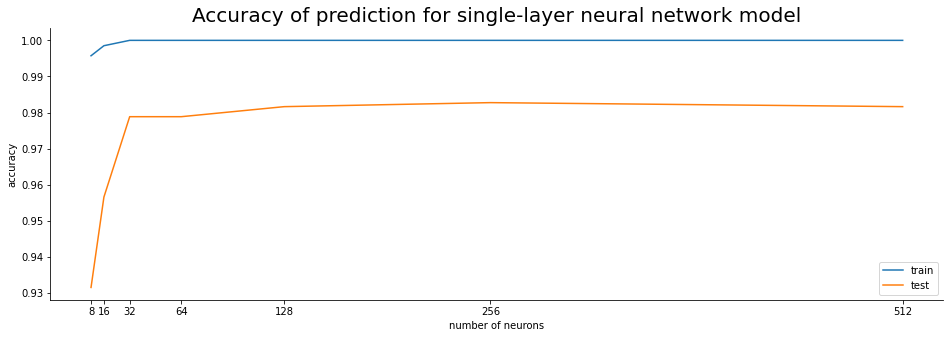

In [31]:
# Show a line graph
fig,ax = plt.subplots(figsize=(16, 5))

plt.plot(numberofneurons, numberofneurons_accuracies_train, label = 'train')
plt.plot(numberofneurons, numberofneurons_accuracies_test, label = 'test')
plt.title('Accuracy of prediction for single-layer neural network model', fontsize=20)
ax.set_xticks(numberofneurons)
ax.set_xlabel('number of neurons')
ax.set_ylabel('accuracy')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Observations:
* Adding more neurons to the model does increase its accuracy a lot, although this effect flattens out above 32 neurons.
* The highest accuracy is with 256 neurons: 98.3%.
* The model performs very well when applied on the training data itself: the accuracy reaches 100%.

So the model does seem to overfit somewhat, given the gap between results on the test data and the training data. This implies that the number that we see for accuracy (on the test data) may be a less reliable number. One thing that we can play with still is the number of folds, and see what impact that has.

Let's try out with 8 folds instead of 4 (for a limited set of neurons-per-layer) 

In [32]:
# Run cross-validation for MLP for different values of hidden-layer-sizes (nr of neurons)
# WITH 8 FOLDS INSTEAD OF 4

# Instantiate list with range of number of neurons
numberofneurons = [32, 64, 128, 256]

# Instantiate the corresponding arrays that the model needs as input
hiddenlayersizes_arrays = [(32,),(64,),(128,),(256,)]

# Instantiate list with results
numberofneurons_accuracies = []

# Run MLP-cross-validation (in its turn running train and test) for all hiddenlayersizes in the specified range
for hls_array in hiddenlayersizes_arrays:
    # Calculate accuracy (cross-validated)
    hls_accuracy = mlp_cross_validate(digits.data, digits.target, folds = 8, hiddenlayersizes = hls_array, maxiterations = 1500)
    
    # Append result
    numberofneurons_accuracies.append(hls_accuracy)
    
# Print results    
print('Number of neurons (in single layer):', numberofneurons)
print('Corresponding accuracies, with 8-fold cross-validation:', numberofneurons_accuracies)

Number of neurons (in single layer): [32, 64, 128, 256]
Corresponding accuracies, with 8-fold cross-validation: [(1.0, 0.9799702380952381), (1.0, 0.9799751984126984), (1.0, 0.981641865079365), (1.0, 0.9860962301587302)]


The earlier results were:
* 32 neurons (4 folds): (1.0, 0.9788554813165058)
* 64 neurons (4 folds): (1.0, 0.9788542439990102)
* 128 neurons (4 folds): (1.0, 0.9816382083642663)
* 256 neurons (4 folds): (1.0, 0.9827505567928732)

There are some differences. For 32 and 64 neurons the result is 0.1% lower, for 128 is remains the same, while for 256 (the most accurate model), the calculated accuracy for the test set went up from 98.3% to 98.6%. 

It's hard to draw any conclusions from that. What it does mean is that we are not entirely sure how well our models would perform on unseen data. As when doing experiments with varying selections of training data and test data (which is what we do with k-fold validation) we get different results. In fact, we also could see that already in the experiments in which we printed the accuracy for each of the folds: there were quite significant difference between them.

While we might want to experiment further with that, let us for comparing to KNN just stick to the numbers using 4 folds, since that is what we used for KNN as well. So far, the neural network did not beat the KNN result yet.

Rather, let's continue now with a neural network with more than one layer.

## 4. Neural network (multiple hidden layers)

Let's now train/test a neural network with 2 hidden layers, and then with 64 and with 128 neurons per layer. We'll stick to 4 folds for cross-validation.

We can reuse all functions created above, just with different input data.

In [33]:
# Run cross-validation for MLP for different values of hidden-layer-sizes 

# Instantiate list with range of number of neurons per layer
numberofneurons = [64, 128]

hiddenlayersizes_arrays = [(64,64),(128,128)]

# Instantiate list with results
hiddenlayersizes_accuracies = []

# Run MLP-cross-validation (in its turn running train and test) for all hiddenlayersizes in the specified range
for hls_array in hiddenlayersizes_arrays:
    # Calculate accuracy (cross-validated)
    hls_accuracy = mlp_cross_validate(digits.data, digits.target, hiddenlayersizes = hls_array, maxiterations = 1500)
    
    # Append result
    hiddenlayersizes_accuracies.append(hls_accuracy)

# Print results    
print('Number of neurons (in both of two hidden layers):', numberofneurons)
print('Corresponding accuracies:', hiddenlayersizes_accuracies)

Number of neurons (in both of two hidden layers): [64, 128]
Corresponding accuracies: [(1.0, 0.9721776787923782), (1.0, 0.9799690670626082)]


Looks like the accuracy is quite similar to the network with one layer only, if anything it is actually a bit lower!

Let us add one more hidden layer (a third one), and again train/test with 64 and 128 neurons per layer.

In [34]:
# Run cross-validation for MLP for different values of hidden-layer-sizes 

# Instantiate list with range of number of neurons per layer
numberofneurons = [10, 64, 128]

hiddenlayersizes_arrays = [(10,10,10),(64,64,64),(128,128,128)]

# Instantiate list with results
hiddenlayersizes_accuracies = []

# Run MLP-cross-validation (in its turn running train and test) for all hiddenlayersizes in the specified range
for hls_array in hiddenlayersizes_arrays:
    # Calculate accuracy (cross-validated)
    hls_accuracy = mlp_cross_validate(digits.data, digits.target, hiddenlayersizes = hls_array, maxiterations = 1500)
    
    # Append result
    hiddenlayersizes_accuracies.append(hls_accuracy)

# Print results    
print('Number of neurons (in each of three hidden layers):', numberofneurons)
print('Corresponding accuracies:', hiddenlayersizes_accuracies)

Number of neurons (in each of three hidden layers): [10, 64, 128]
Corresponding accuracies: [(0.9959194682545452, 0.8953823311061618), (1.0, 0.9655011135857461), (1.0, 0.9744036129670873)]


Interesting, the results are again a bit worse than with 2 layers.

So it seems that adding more hidden layers to our neural network only makes things worse. The accuracy on the training data itself remains at 100% (or very close to it). So what I think this means, is that adding more layers makes the model more prone to overfitting. Some searching on the internet about what I observe (more layers, lower accuracy) seems to confirm that that is possible.

Given that adding more layers doesn't seem to improve accuracy, doing runs with different numbers of folds doesn't seem to be useful. Rather, let us summarize the results, including a comparison with KNN.

## 5. Conclusions and possible next steps

In this project, we've trained multiple machine learning models to classify handwritten digits (0-9), and tested them on 'unseen' data. Accuracy was defined as 'percentage correct predictions'. K-fold validation was used to calculate this accuracy, where for all results below 4 folds were used, and the same folds were applied for all experiments to enable a fair comparison. 

Models that were used were KNN (k nearest neighbours) for classification, and MLP (neural network). For both of them, several hyperparameters were subject to experimenting.

Main conclusions:
* Using KNN (k nearest neighbors), the best result was achieved for k=1 (one nearest neighbor), reaching an accuracy of 98.7% on the test set.
* Using MLP (multi-layer perceptron neural network), the best result was achieved with a network with a single hidden layer with 256 neurons, reaching an accuracy of 98.3%.
* Simpler MLP models with less neurons in this single hidden layer network (e.g. 32, 64, 128) only imply a very small decrease in accuracy. Adding more layers to the neural network makes things worse.
* The MLP neural network tends to overfit: when testing on the training data itself, accuracy is always 100% (or very close to it).
* In particular for MLP there are significant differences between the folds in terms of accuracy, and also changing the number of folds gives somewhat different results, implying that the calculated accuracy number is not extremely precise in case you want to use it as an indicator how well such model may perform in a 'live' environment.

I must say that I am surprised to see that KNN gave better results than the MLP neural network, the latter being hailed so much for its ability to do a task such as image classification. (To be frank: it makes me wonder whether I made a mistake somewhere.)

Possible next steps:
* Do more experiments with different numbers of folds (for k-fold validation), to get more confidence in the predicted model accuracies for all models used.
* Try out whether the performance of the neural network can still be improved. E.g. try out a different activation function.
* Try out different machine learning models, e.g. decision trees of random forest.